In [1]:
import numpy as np
from scipy.linalg import block_diag
from adaptive_latents.regressions import VanillaOnlineRegressor
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [3]:
def make_H(d):
    h = []
    for i in range(0,d):
        for j in range(0,i):
            a = np.zeros((d,d))
            a[i,j] = 1
            a[j,i] = -1
            h.append(a.flatten())
    return np.column_stack(h)

def test_make_H(dd=10):
    for d in range(2,dd):
        H = make_H(d)
        for _ in range(100):
            k = rng.normal(size=int(d*(d-1)/2))
            sksym = (H @ k).reshape((d,d))
            assert np.linalg.norm(np.real(np.linalg.eigvals(sksym))) < 1e-14
test_make_H()

In [4]:
m, n = 1000,3
H = make_H(n)
X = rng.random((m,n))
M = rng.random((n,n))
# k = rng.normal(size=int(n*(n-1)/2)); M = (H @ k).reshape(n,n)

X_dot = X @ M
X = X

In [8]:
def make_X_tilde(X, order='C'):
    m,n = X.shape
    if order=='C':
        X_tilde = np.zeros(shape=(m*n, n*n))
        for i in range(m):
            for j in range(n):
                X_tilde[i*n+j, j*n:(j+1)*n] = X[i]
    elif order == 'F':
        X_tilde = block_diag(*[X]* n)
    return X_tilde

In [111]:
order = 'C'
x_dot = X_dot.ravel(order)
X_tilde = make_X_tilde(X, order)
beta, residuals, rank, s = np.linalg.lstsq(X_tilde@H, x_dot, rcond=None)

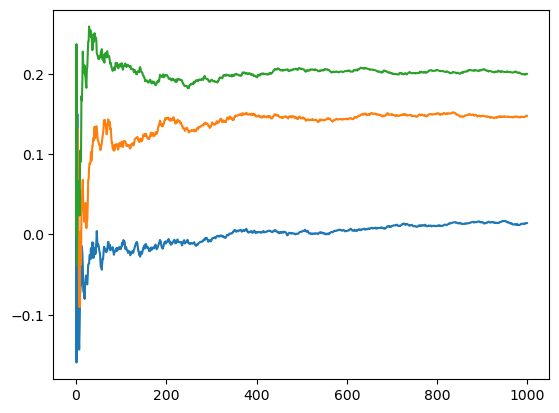

In [112]:
order = 'C'
betas = []
for init_size in range(m):
    W = (make_X_tilde(X[:init_size], order) @ H)
    D = np.linalg.pinv(W.T @ W)
    c = W.T @ X_dot[:init_size].ravel(order)
    betas.append(D@c)
betas = np.array(betas)
plt.plot(betas)

0.05874617178103448

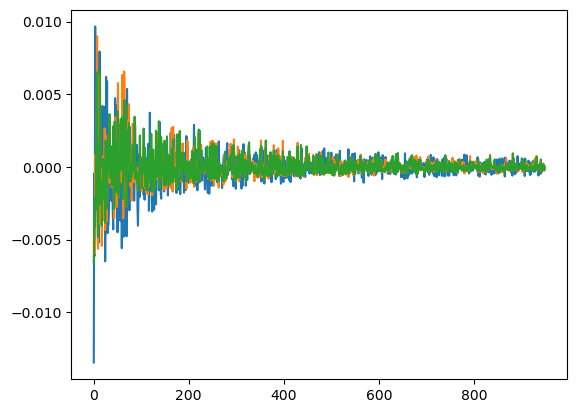

In [15]:
order = 'C'
betas_r = []
betas = []
init_size = 50

W = (make_X_tilde(X[:init_size], order) @ H)
D = np.linalg.pinv(W.T @ W)
c = W.T @ X_dot[:init_size].ravel(order)


D_r = np.array(D)
c_r = np.array(c)
for i in range(init_size,m):
    rows = make_X_tilde(X[i,None], order) @ H
    for j in range(n):
        row = (rows[j, None]).T
        D_r = D_r - (D_r @ row @ row.T @ D_r) / (1 + row.T @ D_r @ row)
        c_r += row.flatten() * X_dot[i,j]
    betas_r.append(D_r@c_r)

    W = (make_X_tilde(X[:i], order) @ H)
    beta, _, _, _ = np.linalg.lstsq(W, X_dot[:i].ravel(order), rcond=None)
    betas.append(beta)
betas_r = np.squeeze(betas_r)
betas = np.squeeze(betas)
# plt.plot(betas, 'k')
plt.plot(betas_r- betas)
np.linalg.norm(betas - betas_r)

In [17]:
def make_H(d):
    h = []
    for i in range(0,d):
        for j in range(0,i):
            a = np.zeros((d,d))
            a[i,j] = 1
            a[j,i] = -1
            h.append(a.flatten())
    return np.column_stack(h)

def make_X_tilde(X, order='C'):
    m,n = X.shape
    if order=='C':
        X_tilde = np.zeros(shape=(m*n, n*n))
        for i in range(m):
            for j in range(n):
                X_tilde[i*n+j, j*n:(j+1)*n] = X[i]
    elif order == 'F':
        X_tilde = block_diag(*[X]* n)
    return X_tilde

reg = VanillaOnlineRegressor(input_d=H.shape[1], output_d=1, init_min_ratio=2)

for i in range(X.shape[0]):
    rows = make_X_tilde(X[i,None]) @ H
    for j in range(n):
        x = rows[j]
        y = X_dot[i,j]
        reg.safe_observe(x, y)

reg.get_beta().T - betas[-1]

array([[-1.17219639e-04, -1.06173706e-05,  2.99773167e-05]])